In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame

%matplotlib inline
pd.options.display.mpl_style = 'default'

pd.set_option('display.max_columns', 36)
#print pd.__version__

%load_ext rpy2.ipython

0.18.0


Using NLTK to preprocess and tokenizing the data

In [3]:
import nltk
import string
from nltk import word_tokenize
from nltk.util import bigrams, trigrams
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter

In [4]:
PROCESSED_YELP_JSON_DATA_DIR = '../yelp_dataset_challenge_academic_dataset/Processed_Data_Dir'
YELP_OUTPUT_DIR = os.path.join('../yelp_dataset_challenge_academic_dataset/', 'Output_Directory')

!echo PROCESSED_YELP_JSON_DATA_DIR : $PROCESSED_YELP_JSON_DATA_DIR
!ls -sh $PROCESSED_YELP_JSON_DATA_DIR
### running this command can cause the notebook to throw
### a kernel dead error as the library is huge, download
### it using python terminal

## download the english stopwords corpus and the punkt 
## package and also the porter stemmer if not present

# nltk.download()

PROCESSED_YELP_JSON_DATA_DIR : ../yelp_dataset_challenge_academic_dataset/Processed_Data_Dir
total 12173440
 619968 TURBO_p1.csv
 109024 yelp_academic_dataset_business.csv
 134992 yelp_academic_dataset_business.json
  49952 yelp_academic_dataset_checkin.json
3794912 yelp_academic_dataset_review.json
1637640 yelp_academic_dataset_review_p1.json
1629472 yelp_academic_dataset_review_p2.json
1580952 yelp_academic_dataset_review_p3.json
1665400 yelp_academic_dataset_review_p4.json
 233008 yelp_academic_dataset_tip.json
 255360 yelp_academic_dataset_user.csv
 462760 yelp_academic_dataset_user.json


Even though NLTK consists of a huge library of stop words we're downloading some extra stopwords and also sentiment/opinion datasets, just in case if it needs to be used in future

In [17]:
%%bash
# using https://sites.google.com/site/kevinbouge/stopwords-lists repo
wget --quiet --output-document=more_stopwords.txt http://sites.google.com/site/kevinbouge/stopwords-lists/stopwords_en.txt?attredirects=0&d=1

wget --quiet --output-document=opinions.rar http://www.cs.uic.edu/~liub/FBS/opinion-lexicon-English.rar
unrar e -o+ --silent opinions.rar > /dev/null

## for running this commands on UBUNTU use 
## sed -i '/^;/d' positive-words.txt ## format
## OS X ships with BSD sed, 
## where the suffix is mandatory. Thus using 
## sed -i '' 
sed -i '' '/^;/d' positive-words.txt

## Using LANG=C as to avoid 'illegal byte sequence' err
## Without LANG=C sed assumes that files are encoded 
## in whatever encoding is specified in LANG and the 
## file (being binary) may contain bytes which are not 
## valid characters in LANG's encoding.
## Using C as it happens to treat all ASCII characters 
## as themselves and non-ASCII characters as literals.
LANG=C sed -i '' '/^;/d' negative-words.txt

In [11]:
POSITIVE_WORDS_SET = set([line.strip() for line in open('positive-words.txt', 'r')])
NEGATIVE_WORDS_SET = set([line.strip() for line in open('negative-words.txt', 'r')])
NLTK_STOPWORDS_SET = set(stopwords.words('english'))
MORE_STOPWORDS_SET = set([line.strip() for line in open('more_stopwords.txt', 'r')])

def rmv_num_from_str(_str):
    return _str.translate(None, string.digits)

def lower_case_rmv_punctuation(_str):
    _str = _str.lower()
    _str = _str.translate(None, string.punctuation)
    return _str
    
def rmv_stopwords(_str):
    token_list = nltk.word_tokenize(_str)
    exclude_stopwords = lambda _token : _token not in NLTK_STOPWORDS_SET
    return ' '.join(filter(exclude_stopwords, token_list))

def filter_more_stopwords(token_list):
    return filter(lambda _token : _token not in MORE_STOPWORDS_SET, token_list)

def stemmer_token_list(token_list):
    STEMMER = PorterStemmer()
    return [STEMMER.stem(_token.decode('utf-8')) for _token in token_list]

def restring_tokens(token_list):
    return ' '.join(token_list)

def lower_case_rmv_punctuation_and_numbers_and_tokenize_and_filter_more_stopwords_and_stem_and_restring(_str):
    _str = rmv_num_from_str(_str)
    _str = lower_case_rmv_punctuation(_str)
    _str = rmv_stopwords(_str)
    token_list = nltk.word_tokenize(_str)
    token_list = filter_more_stopwords(token_list)
    token_list = stemmer_token_list(token_list)
    return restring_tokens(token_list)

def lower_case_rmv_punctuation_and_tokenize(s):
    s = s.lower()
    s = s.translate(None, string.punctuation)
    # may consider removing arabic-hindu digits
    token_list = nltk.word_tokenize(s)
    exclude_stopwords = lambda token : token not in NLTK_STOPWORDS_SET
    return filter(exclude_stopwords, token_list)

def concatenate_and_preprocess_and_tokenize_review_texts(sub_dataframe):
    s = sub_dataframe.review_text.sum()
    return lower_case_rmv_punctuation_and_tokenize(s)

Using the dataset BRUT created with Preprocessing Script

In [22]:
brut_csv_filename = os.path.join("./", 'BRUT_p1.csv')
BRUT_DATA_FRAME = pd.read_csv(brut_csv_filename)
BRUT_DATA_FRAME.head()

,attributes,business_id,categories,city,full_address,hours,latitude,longitude,business_name,neighborhoods,open,business_review_count,business_stars,state,type_x,review_date,review_id,review_stars,review_text,type_y,user_id,review_votes,average_stars,compliments,elite,fans,friends,user_name,user_review_count,type_x.1,user_votes,yelping_since,tip_date,likes,tip_text,type_y.1
0,{},6c2pWWtdQZA3w5raX6k-dg,"[Barbers, Beauty & Spas]",Homestead,"3510 Main St\nHomestead, PA 15120","{u'Tuesday': {u'close': u'17:30', u'open': u'0...",40.385508,-79.903491,Carmine's Barber Shop,[],True,3,3.5,PA,business,2014-04-23,OdwBV3AkP9sm3AxgDmuX2A,5,Great place to get a basic haircut at a fair p...,review,I_47G-R2_egp7ME5u_ltew,"{u'funny': 0, u'useful': 0, u'cool': 0}",3.18,{u'hot': 1},[],1,"[DsN2dJ6SnTEACr1qC5zpGg, UD7Y1CqfY6mDmRwIuCf6n...",Kevin,47,user,"{u'funny': 8, u'useful': 46, u'cool': 10}",2011-11,2014-07-14,0,I've been told that they do open at 4 AM and i...,tip
1,"{u'Alcohol': u'beer_and_wine', u'Noise Level':...",Q4ULAiIE2qCA4RYplCTrUQ,"[Nightlife, Bars, Sandwiches, Restaurants]",Pittsburgh,"46 18th St\nStrip District\nPittsburgh, PA 15222","{u'Monday': {u'close': u'06:00', u'open': u'06...",40.450742,-79.985538,Primanti Brothers,[Strip District],True,813,3.5,PA,business,2014-03-29,Hemfg9NKZ24bKkGvqnqs5g,4,I love Primantis and this location has some ch...,review,I_47G-R2_egp7ME5u_ltew,"{u'funny': 0, u'useful': 0, u'cool': 0}",3.18,{u'hot': 1},[],1,"[DsN2dJ6SnTEACr1qC5zpGg, UD7Y1CqfY6mDmRwIuCf6n...",Kevin,47,user,"{u'funny': 8, u'useful': 46, u'cool': 10}",2011-11,2015-10-21,0,They take credit cards now!,tip
2,"{u'Take-out': True, u'Price Range': 2, u'Outdo...",1qCuOcks5HRv67OHovAVpg,"[Pubs, Bars, American (New), Nightlife, Restau...",Homestead,"122 W 8th Ave\nHomestead\nHomestead, PA 15120",{},40.405311,-79.912595,Duke's Upper Deck Cafe,[Homestead],True,26,3.5,PA,business,2014-09-13,1tZARkIiC89Xhqd6AHLrbg,4,Food is good here. Great beer selection on tap...,review,JPPhyFE-UE453zA6K0TVgw,"{u'funny': 0, u'useful': 0, u'cool': 0}",4.21,"{u'funny': 5, u'plain': 9, u'writer': 14, u'no...","[2014, 2015]",7,"[fwsJGulnozT2U6FefsLiFw, Dsh4UCo9ny0XCrEJaF4aK...",Molly,146,user,"{u'funny': 36, u'useful': 136, u'cool': 70}",2012-06,2014-10-18,0,Half priced appetizers after 9 on week nights.,tip
3,"{u'Alcohol': u'beer_and_wine', u'Open 24 Hours...",2X5G4Ujq0s4Wfn4TC7gX0g,"[Pubs, Bars, Hot Dogs, Nightlife, Restaurants]",Pittsburgh,"1118 S Braddock Ave\nPittsburgh, PA 15218","{u'Monday': {u'close': u'23:00', u'open': u'11...",40.432022,-79.893834,D's Six Pax & Dogz,[],True,266,4.5,PA,business,2014-09-13,qs7jdIz-g-KC6BGDZCD-Fg,4,"While everyone goes here for the dogs, the piz...",review,JPPhyFE-UE453zA6K0TVgw,"{u'funny': 0, u'useful': 0, u'cool': 0}",4.21,"{u'funny': 5, u'plain': 9, u'writer': 14, u'no...","[2014, 2015]",7,"[fwsJGulnozT2U6FefsLiFw, Dsh4UCo9ny0XCrEJaF4aK...",Molly,146,user,"{u'funny': 36, u'useful': 136, u'cool': 70}",2012-06,2014-10-18,0,The special hummus is always good. Take a brea...,tip
4,{u'Good for Kids': True},cE27W9VPgO88Qxe4ol6y_g,"[Active Life, Mini Golf, Golf]",Bethel Park,"1530 Hamilton Rd\nBethel Park, PA 15234",{},40.354116,-80.014660,Cool Springs Golf Center,[],False,5,2.5,PA,business,2013-04-18,rkD7UDbQ9VM3Va6bI-eBHQ,1,Owning a driving range inside the city limits ...,review,-6rEfobYjMxpUWLNxszaxQ,"{u'funny': 0, u'useful': 1, u'cool': 0}",3.28,"{u'note': 1, u'plain': 1, u'cool': 3}",[],1,"[nEYPahVwXGD2Pjvgkm7QqQ, ukf5AhPo3dJhEWB2km-St...",Andrew,29,user,"{u'funny': 18, u'useful': 61, u'cool': 11}",2012-11,2013-04-18,0,Don't waste your time.,tip


In [23]:
for idx in range(5):
    print BRUT_DATA_FRAME.review_text[idx]
    print

Great place to get a basic haircut at a fair price! The barbers are like local historians and seem to know something about everybody in town. You might have to wait a bit sometimes to get a haircut, seeing as there is normally only one or two guys working, but the wait normally goes by fast.

I love Primantis and this location has some characters working there. My only problem with this location is that their fries on the sandwiches almost always seem to be undercooked.

Food is good here. Great beer selection on tap. Sometimes the beer is on the pricey side. What I want from a neighborhood bar is a neighborhood special. Pinkerton is one of the best sandwiches. Good place to watch football, hockey, baseball.

While everyone goes here for the dogs, the pizza is not be ignored. Hand tossed crusts with a nice selection of specialty pizzas. 

Appetizers are good as well. Hummus is a solid choice. Not a fan of their wings. 

Beer selection is on point and if you can't find what you want on 

In [24]:
initial_features = ['business_id', 'business_name', 'review_stars', 'review_text']
df_with_initial_features_and_preprocessed_review_text = BRUT_DATA_FRAME[initial_features]
%time df_with_initial_features_and_preprocessed_review_text['review_text'] = df_with_initial_features_and_preprocessed_review_text['review_text'].apply(lower_case_rmv_punctuation_and_numbers_and_tokenize_and_filter_more_stopwords_and_stem_and_restring)

for idx in range(5):
    print df_with_initial_features_and_preprocessed_review_text.review_text[idx]
    print

CPU times: user 4min 25s, sys: 3.53 s, total: 4min 28s
Wall time: 4min 28s
great place basic haircut fair price barber local historian town wait bit haircut guy work wait fast

love primanti locat charact work problem locat fri sandwich undercook

food good great beer select tap beer pricey side neighborhood bar neighborhood special pinkerton sandwich good place watch footbal hockey basebal

dog pizza hand toss crust nice select specialti pizza appet good hummu solid choic fan wing beer select point find tap head beer cave find crazi varieti beer busi prepar wait

own drive rang insid citi limit licens print money dont drive rang decent mat clean ball access hour hell peopl advent machin dole ball place april grass tee btw open season week golf weather month mat carpet year aunt iren hous worn thread bare let talk hour place equip light sell bucket ball light final let pit hit arriv wasnt drive rang excav site mastodon strip mine oper grass rang mud make good tool figur hit ball cash b

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Importing sklearn functions and partitioning the data into training and test subsets.

In [27]:
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import *
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, roc_auc_score

In [28]:
TEST_SIZE = 0.40
train_X, test_X, train_y, test_y = train_test_split(df_with_initial_features_and_preprocessed_review_text.review_text,
                                                    df_with_initial_features_and_preprocessed_review_text.review_stars,
                                                    test_size=TEST_SIZE,
                                                    random_state=42)

In [29]:
bag_of_words_vectorizer = CountVectorizer(analyzer = "word",
                                          tokenizer = None,    
                                          preprocessor = None,
                                          ngram_range = (1, 1),
                                          binary = False,
                                          strip_accents='unicode')

binary_vectorizer = CountVectorizer(analyzer = "word",
                                    tokenizer = None,    
                                    preprocessor = None,
                                    ngram_range = (1, 1),
                                    binary = True,
                                    strip_accents='unicode')

bigram_vectorizer = CountVectorizer(analyzer = "word",
                                    tokenizer = None,
                                    preprocessor = None,
                                    ngram_range = (2, 2),
                                    strip_accents='unicode')

trigram_vectorizer = CountVectorizer(analyzer = "word",
                                     tokenizer = None,
                                     preprocessor = None,
                                     ngram_range = (3, 3),
                                     strip_accents='unicode')

random_forest_vectorizer = CountVectorizer(analyzer = "word",
                                           tokenizer = None,
                                           preprocessor = None,
                                           ngram_range = (1,1),
                                           strip_accents = 'unicode',
                                           max_features = 1000)

<h2> Bag of Words Model </h2>

Transforming the Yelp review into feature vectors

In [30]:
bow_feature_matrix_train_set = bag_of_words_vectorizer.fit_transform(train_X)
bow_feature_matrix_test_set = bag_of_words_vectorizer.transform(test_X)
bow_feature_matrix_train_set, bow_feature_matrix_test_set

(<61396x55969 sparse matrix of type '<type 'numpy.int64'>'
 	with 2413216 stored elements in Compressed Sparse Row format>,
 <40932x55969 sparse matrix of type '<type 'numpy.int64'>'
 	with 1604301 stored elements in Compressed Sparse Row format>)

Perform predictions for multinomial Naive Bayes

In [32]:
multinomial_naive_bayes_classifier = MultinomialNB()
multinomial_naive_bayes_classifier.fit(bow_feature_matrix_train_set, train_y)
multinomial_naive_bayes_prediction = multinomial_naive_bayes_classifier.predict(bow_feature_matrix_test_set)

Visualizing through Confusion matrix

In [33]:
def make_confusion_matrix_relative(confusion_matrix):
    star_category_classes = [1, 2, 3, 4, 5]
    N = map(lambda clazz : sum(test_y == clazz), star_category_classes)
    relative_confusion_matrix = np.empty((len(star_category_classes), len(star_category_classes)))
    
    for j in range(0, len(star_category_classes)):
        if N[j] > 0:
            relative_frequency = confusion_matrix[j, :] / float(N[j])
            relative_confusion_matrix[j, :] = relative_frequency
            
    return relative_confusion_matrix

def plot_confusion_matrix(confusion_matrix=[[]], title='CM', savefilename=''):
    rcm = make_confusion_matrix_relative(confusion_matrix)
    c = plt.pcolor(rcm, edgecolors='k', linewidths=4, cmap='jet', vmin=0.0, vmax=1.0)
    plt.title(title)
    plt.colorbar()
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.xticks(0.5 + np.arange(5), np.arange(1,6))
    plt.yticks(0.5 + np.arange(5), np.arange(1,6))

    def show_values(pc, fmt="%.2f", **kw):
        from itertools import izip
        pc.update_scalarmappable()
        ax = pc.get_axes()
        for p, color, value in izip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if sum(color[:2] > 0.3) >= 2:
                color = (0.0, 0.0, 0.0)
            else:
                color = (1.0, 1.0, 1.0)
            ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)
    
    show_values(c)

    if savefilename:
        plt.savefig(savefilename, bbox_inches='tight')
    
    return plt.show()

[[ 0.6535163   0.03361921  0.1084048   0.12178388  0.08267581]
 [ 0.20730634  0.14040493  0.23591549  0.29049296  0.12588028]
 [ 0.05600331  0.00847282  0.30481504  0.44905972  0.1816491 ]
 [ 0.0185171   0.00229551  0.05470962  0.58122274  0.34325503]
 [ 0.01878119  0.0016819   0.01435219  0.19218478  0.77299994]]


/usr/local/lib/python2.7/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


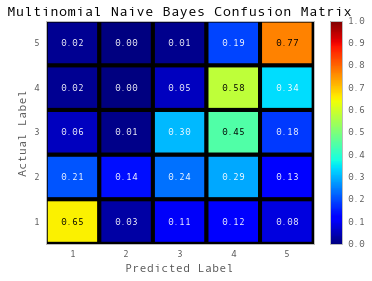

In [34]:
multinomial_confusion_matrix = confusion_matrix(test_y, multinomial_naive_bayes_prediction)
print make_confusion_matrix_relative(multinomial_confusion_matrix)
plot_confusion_matrix(multinomial_confusion_matrix, 'Multinomial Naive Bayes Confusion Matrix', savefilename='MultinomialCM.png')

Print classifier performance metrics

In [35]:
def print_classifier_performance_metrics(name, predictions):
    target_names = ['1 star', '2 star', '3 star', '4 star', '5 star']
    
    print "MODEL: %s" % name
    print

    print 'Precision: ' + str(metrics.precision_score(test_y, predictions))
    print 'Recall: ' + str(metrics.recall_score(test_y, predictions))
    print 'F1: ' + str(metrics.f1_score(test_y, predictions))
    print 'Accuracy: ' + str(metrics.accuracy_score(test_y, predictions))

    print
    print 'Classification Report:'
    print classification_report(test_y, predictions, target_names=target_names)
    
    print
    print 'Precision variance: %f' % np.var(precision_score(test_y, predictions, average=None), ddof=len(target_names)-1)
    
    print
    print 'Recall variance: %f' % np.var(recall_score(test_y, predictions, average=None), ddof=len(target_names)-1)

In [36]:
print_classifier_performance_metrics('Multinomial Naive Bayes', multinomial_naive_bayes_prediction)

MODEL: Multinomial Naive Bayes

Precision: 0.605092587679
Recall: 0.612796833773
F1: 0.597855467975
Accuracy: 0.612796833773

Classification Report:
             precision    recall  f1-score   support

     1 star       0.59      0.65      0.62      2915
     2 star       0.62      0.14      0.23      2272
     3 star       0.45      0.30      0.36      4839
     4 star       0.53      0.58      0.56     13069
     5 star       0.70      0.77      0.74     17837

avg / total       0.61      0.61      0.60     40932


Precision variance: 0.035622

Recall variance: 0.271657


/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

<h3>Bernoulli Naive Bayes Model</h3>

Transforming Yelp Reviews into feature vectors by binarizing unigram occurences

In [37]:
bernoulli_feature_matrix_train_set = binary_vectorizer.fit_transform(train_X)
bernoulli_feature_matrix_test_set = binary_vectorizer.transform(test_X)
bernoulli_feature_matrix_train_set, bernoulli_feature_matrix_test_set

(<61396x55969 sparse matrix of type '<type 'numpy.int64'>'
 	with 2413216 stored elements in Compressed Sparse Row format>,
 <40932x55969 sparse matrix of type '<type 'numpy.int64'>'
 	with 1604301 stored elements in Compressed Sparse Row format>)

Making predictions with Bernoulli Naive Bayes

In [38]:
bernoulli_nb_classifier = BernoulliNB().fit(bernoulli_feature_matrix_train_set, train_y)
bernoulli_nb_prediction = bernoulli_nb_classifier.predict(bernoulli_feature_matrix_test_set)

Visualizing through a Confusion Matrix

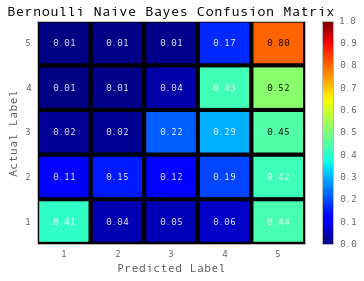

In [39]:
bernoulli_confusion_matrix = confusion_matrix(test_y, bernoulli_nb_prediction)
plot_confusion_matrix(bernoulli_confusion_matrix, 'Bernoulli Naive Bayes Confusion Matrix', savefilename='BernoulliCM.png')

In [40]:
print_classifier_performance_metrics('Bernoulli Naive Bayes', bernoulli_nb_prediction)

MODEL: Bernoulli Naive Bayes

Precision: 0.539388036056
Recall: 0.549496726278
F1: 0.522286999284
Accuracy: 0.549496726278

Classification Report:
             precision    recall  f1-score   support

     1 star       0.67      0.41      0.51      2915
     2 star       0.40      0.15      0.22      2272
     3 star       0.48      0.22      0.30      4839
     4 star       0.53      0.43      0.47     13069
     5 star       0.56      0.80      0.66     17837

avg / total       0.54      0.55      0.52     40932


Precision variance: 0.039101

Recall variance: 0.259381


/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

<h3>Bigram Naive Bayes Model</h3>

Transforming Yelp reviews into feature vectorizers by counting bigram occurences

In [41]:
bigram_multinomial_feature_matrix_train_set = bigram_vectorizer.fit_transform(train_X)
bigram_multinomial_feature_matrix_test_set = bigram_vectorizer.transform(test_X)
bigram_multinomial_feature_matrix_train_set, bigram_multinomial_feature_matrix_test_set

(<61396x1021993 sparse matrix of type '<type 'numpy.int64'>'
 	with 2843728 stored elements in Compressed Sparse Row format>,
 <40932x1021993 sparse matrix of type '<type 'numpy.int64'>'
 	with 1478339 stored elements in Compressed Sparse Row format>)

Making predictions using Bigram Multinomial Naive Bayes

In [42]:
bigram_multinomial_naive_bayes_classifier = MultinomialNB().fit(bigram_multinomial_feature_matrix_train_set, train_y)
bigram_multinomial_naive_bayes_prediction = bigram_multinomial_naive_bayes_classifier.predict(bigram_multinomial_feature_matrix_test_set)

Visualize through confusion matrix

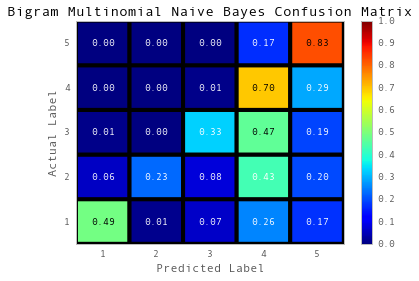

In [43]:
bigram_multinomial_confusion_matrix = confusion_matrix(test_y, bigram_multinomial_naive_bayes_prediction)
plot_confusion_matrix(bigram_multinomial_confusion_matrix, 'Bigram Multinomial Naive Bayes Confusion Matrix', savefilename='BigramMultinomialCM.png')

In [44]:
print_classifier_performance_metrics('Bigram Multinomial Naive Bayes', bigram_multinomial_naive_bayes_prediction)

MODEL: Bigram Multinomial Naive Bayes

Precision: 0.693281628643
Recall: 0.668572266198
F1: 0.653180899225
Accuracy: 0.668572266198

Classification Report:
             precision    recall  f1-score   support

     1 star       0.85      0.49      0.62      2915
     2 star       0.90      0.23      0.37      2272
     3 star       0.75      0.33      0.46      4839
     4 star       0.56      0.70      0.62     13069
     5 star       0.72      0.83      0.77     17837

avg / total       0.69      0.67      0.65     40932


Precision variance: 0.067726

Recall variance: 0.245163


/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

<h3> Trigram Naive Bayes Model</h3>

Transform Yelp reviews into feature vectorizers by counting trigram occurrences

In [45]:
trigram_multinomial_feature_matrix_train_set = trigram_vectorizer.fit_transform(train_X)
trigram_multinomial_feature_matrix_test_set = trigram_vectorizer.transform(test_X)
trigram_multinomial_feature_matrix_train_set, trigram_multinomial_feature_matrix_test_set

(<61396x1913372 sparse matrix of type '<type 'numpy.int64'>'
 	with 2832996 stored elements in Compressed Sparse Row format>,
 <40932x1913372 sparse matrix of type '<type 'numpy.int64'>'
 	with 885830 stored elements in Compressed Sparse Row format>)

Make predictions with Trigram Multinomial NB

In [46]:
tri_gram_multinomial_naive_bayes_classifier = MultinomialNB().fit(trigram_multinomial_feature_matrix_train_set, train_y)
tri_gram_multinomial_naive_bayes_prediction = tri_gram_multinomial_naive_bayes_classifier.predict(trigram_multinomial_feature_matrix_test_set)

Visualizing through confusion matrix

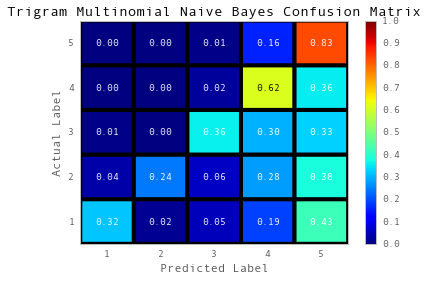

In [47]:
trigram_multinomial_confusion_matrix = confusion_matrix(test_y, tri_gram_multinomial_naive_bayes_prediction)
plot_confusion_matrix(trigram_multinomial_confusion_matrix, 'Trigram Multinomial Naive Bayes Confusion Matrix', savefilename='TrigramMultinomialCM.png')

In [48]:
print_classifier_performance_metrics('Trigram Multinomial Naive Bayes', tri_gram_multinomial_naive_bayes_prediction)

MODEL: Trigram Multinomial Naive Bayes

Precision: 0.657624474552
Recall: 0.636641258673
F1: 0.617746334726
Accuracy: 0.636641258673

Classification Report:
             precision    recall  f1-score   support

     1 star       0.83      0.32      0.46      2915
     2 star       0.87      0.24      0.38      2272
     3 star       0.69      0.36      0.47      4839
     4 star       0.60      0.62      0.61     13069
     5 star       0.64      0.83      0.72     17837

avg / total       0.66      0.64      0.62     40932


Precision variance: 0.056194

Recall variance: 0.235903


/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

<h3>Random Forest 100 Learners Model</h3>

In [49]:
randForest100 = RandomForestClassifier(n_estimators = 100, random_state=42)

Trnasforming reviews into feature vectors

In [51]:
random_forest_feature_matrix_train_set = random_forest_vectorizer.fit_transform(train_X)
random_forest_feature_matrix_test_set = random_forest_vectorizer.transform(test_X)

Making predictions with random forest set at 100 learners

In [53]:
%time randForest100.fit(random_forest_feature_matrix_train_set.toarray(), train_y)
forest100_pred = randForest100.predict(random_forest_feature_matrix_test_set.toarray())
np.save('forest100pred', forest100_pred)

CPU times: user 2min 52s, sys: 2.22 s, total: 2min 54s
Wall time: 2min 56s


Visualizing results using a Confusion Matrix

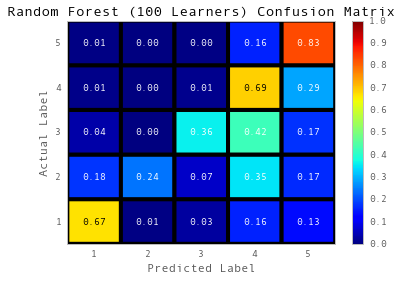

In [54]:
random_forest_confusion_matrix = confusion_matrix(test_y, forest100_pred)
plot_confusion_matrix(random_forest_confusion_matrix, 'Random Forest (100 Learners) Confusion Matrix',
                      savefilename='RandomForestCM.png')

In [55]:
print_classifier_performance_metrics('Random Forest (100 Learners)', forest100_pred)

MODEL: Random Forest (100 Learners)

Precision: 0.704705977267
Recall: 0.686431154109
F1: 0.672571009833
Accuracy: 0.686431154109

Classification Report:
             precision    recall  f1-score   support

     1 star       0.70      0.67      0.68      2915
     2 star       0.92      0.24      0.38      2272
     3 star       0.79      0.36      0.50      4839
     4 star       0.60      0.69      0.64     13069
     5 star       0.73      0.83      0.78     17837

avg / total       0.70      0.69      0.67     40932


Precision variance: 0.058717

Recall variance: 0.243854


/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

In [62]:
from operator import itemgetter

def argmax(dictionary):
    return (max(dictionary.iteritems(), key=itemgetter(1)))[0]

class multinomial_naive_bayes_classifier():
    
    def train(self, class_labels, docs, class_priors=[], complement=False):       
        Classes = sorted(list(set(class_labels)))
        Vocabulary = reduce(lambda V, d : V.union(set(d.split())), docs, set())
        
        if len(class_priors) != len(Classes):
            N_docs_per_class = lambda c : sum(c == np.array(class_labels))
            N_docs = len(docs)
            class_priors = {c : N_docs_per_class(c) / float(N_docs) for c in Classes}
        
        Text_given_class = {c : docs[c == np.array(class_labels)].sum() for c in Classes}
        length_of_concatenated_docs_of_class = {c : len(Text_given_class[c].split()) for c in Classes}
        total_length_of_concatenated_docs_of_all_classes = sum([length_of_concatenated_docs_of_class[C] for C in Classes])
        
        absolute_frequency_vectorizer = CountVectorizer(analyzer = "word",
                                                        vocabulary = Vocabulary,
                                                        ngram_range = (1, 1),
                                                        binary = False)
        documentclass_termunigram_matrix = absolute_frequency_vectorizer.fit_transform(Text_given_class.values())
    
        number_of_feature_words = documentclass_termunigram_matrix.shape[1]
        feature_word_index = dict(zip(absolute_frequency_vectorizer.get_feature_names(), range(number_of_feature_words)))
        word_counts_irregardless_of_class = documentclass_termunigram_matrix.sum(axis=0)
        
        WORD_GIVEN_CLASS_CPT = {}
        COMPLEMENT_WORD_GIVEN_CLASS_CPT = {}
        K = len(Vocabulary)
        
        for class_idx, c in enumerate(Classes):
            if c not in WORD_GIVEN_CLASS_CPT:
                WORD_GIVEN_CLASS_CPT[c] = {}
                COMPLEMENT_WORD_GIVEN_CLASS_CPT[c] = {}

            for w in Vocabulary:
                T_wc = documentclass_termunigram_matrix[class_idx, feature_word_index[w]]
                WORD_GIVEN_CLASS_CPT[c][w] = float(1 + T_wc) / (K + length_of_concatenated_docs_of_class[c])
                
                C_wc = word_counts_irregardless_of_class[0, feature_word_index[w]] - T_wc
                complement_classes_wc = total_length_of_concatenated_docs_of_all_classes-length_of_concatenated_docs_of_class[c]
                COMPLEMENT_WORD_GIVEN_CLASS_CPT[c][w] = float(1 + C_wc) / (K + complement_classes_wc)
           
        self.classes = Classes
        self.vocabulary = Vocabulary
        self.class_priors = class_priors
        self.words_cpt = WORD_GIVEN_CLASS_CPT
        
        if complement:
            self.complement = True
            self.complement_cpt = COMPLEMENT_WORD_GIVEN_CLASS_CPT
        else:
            self.complement = False
            
        return self

    def predict(self, docs):
        target_labels = []
        
        for d in docs:
            score = {}
            Words_d = set(d.split())
            
            for class_idx, c in enumerate(self.classes):
                word_log_likelihoods = np.log([self.words_cpt[c][w] for w in Words_d if w in self.vocabulary])
                score[c] = np.log(self.class_priors[c])
                
                if self.complement:
                    word_in_complement_classes_log_likelihoods = np.log([self.complement_cpt[c][w] for w in Words_d if w in self.vocabulary])
                    score[c] -= sum(word_in_complement_classes_log_likelihoods)
                else:
                    score[c] += sum(word_log_likelihoods)
                    
            c_map = argmax(score)
            target_labels.append(c_map)
            
        return target_labels                            

In [63]:
%time clf = multinomial_naive_bayes_classifier().train(class_labels=train_y, docs=train_X, complement=True)

CPU times: user 5min 36s, sys: 1min 42s, total: 7min 19s
Wall time: 7min 21s


In [64]:
%time pre = clf.predict(test_X)

CPU times: user 17.9 s, sys: 536 ms, total: 18.4 s
Wall time: 18.5 s


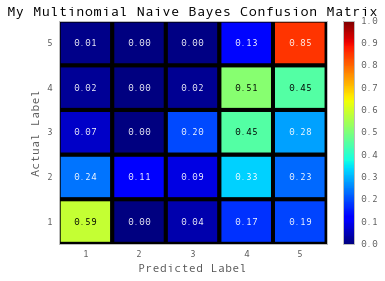

In [65]:
my_multinomial_confusion_matrix = confusion_matrix(test_y, pre)
plot_confusion_matrix(my_multinomial_confusion_matrix,
                      'My Multinomial Naive Bayes Confusion Matrix', savefilename='MyMultinomialCM.png')

In [66]:
print_classifier_performance_metrics('My Multinomial Naive Bayes', pre)

MODEL: My Multinomial Naive Bayes

Precision: 0.615352305695
Recall: 0.607373204339
F1: 0.575482980528
Accuracy: 0.607373204339

Classification Report:
             precision    recall  f1-score   support

     1 star       0.57      0.59      0.58      2915
     2 star       0.89      0.11      0.20      2272
     3 star       0.62      0.20      0.30      4839
     4 star       0.54      0.51      0.52     13069
     5 star       0.65      0.85      0.74     17837

avg / total       0.62      0.61      0.58     40932


Precision variance: 0.078134

Recall variance: 0.364487


/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

<h2>Top 10 Features for each Star Category of Bag of Words Multinomial NB</h2>

In [67]:
N = 10
vocab = np.array([t for t, i in sorted(bag_of_words_vectorizer.vocabulary_.iteritems(), key=itemgetter(1))])

for i, label in enumerate(sorted(set(train_y))):
 top_n_features_indices = np.argsort(multinomial_naive_bayes_classifier.coef_[i])[-N:]
 print "\nThe top %d most informative features for star category %d: \n%s" % (N, label, ", ".join(vocab[top_n_features_indices]))


The top 10 most informative features for star category 1: 
custom, good, wait, dont, back, order, servic, food, time, place

The top 10 most informative features for star category 2: 
wait, im, dont, back, servic, order, time, good, place, food

The top 10 most informative features for star category 3: 
im, back, dont, great, servic, order, time, place, food, good

The top 10 most informative features for star category 4: 
back, nice, servic, order, love, time, food, great, place, good

The top 10 most informative features for star category 5: 
ive, make, order, servic, time, love, good, food, great, place


<h2>Top 10 Features for each Star Category of Bigram Multinomial NB</h2>

In [68]:
N = 10
vocab = np.array([t for t, i in sorted(bigram_vectorizer.vocabulary_.iteritems(), key=itemgetter(1))])

for i, label in enumerate(sorted(set(train_y))):
 top_n_features_indices = np.argsort(bigram_multinomial_naive_bayes_classifier.coef_[i])[-N:]
 print "\nThe top %d most informative features for star category %d: \n%s" % (N, label, ", ".join(vocab[top_n_features_indices]))


The top 10 most informative features for star category 1: 
dont care, park lot, la vega, give star, come back, wast time, wont back, front desk, wait minut, custom servic

The top 10 most informative features for star category 2: 
good food, give star, year ago, servic good, la vega, park lot, happi hour, food good, pretti good, custom servic

The top 10 most informative features for star category 3: 
park lot, good food, late night, ice cream, staff friendli, custom servic, la vega, happi hour, food good, pretti good

The top 10 most informative features for star category 4: 
great food, servic good, love place, staff friendli, good food, food good, great place, pretti good, la vega, happi hour

The top 10 most informative features for star category 5: 
staff friendli, food great, custom servic, happi hour, great servic, highli recommend, great place, great food, la vega, love place


<h3>Wordcloud of 1 to 5 star reviews</h3>

We will interface with both Python and R in order to make the wordclouds. 
Python to format the ngram count data, and 
R to visualize the data respectively.

In [22]:
REVIEW_STARS_BIGRAMS_DIRECTORY = os.path.join(YELP_OUTPUT_DIR, 'review_stars_bigrams')
REVIEW_STARS_TRIGRAMS_DIRECTORY = os.path.join(YELP_OUTPUT_DIR, 'review_stars_trigrams')

if not os.path.exists(REVIEW_STARS_BIGRAMS_DIRECTORY):
    os.makedirs(REVIEW_STARS_BIGRAMS_DIRECTORY)

if not os.path.exists(REVIEW_STARS_TRIGRAMS_DIRECTORY):
    os.makedirs(REVIEW_STARS_TRIGRAMS_DIRECTORY)

In [6]:
brut_csv_filename = os.path.join(PROCESSED_YELP_JSON_DATA_DIR, 'BRUT_p1.csv')
BRUT_DATA_FRAME = pd.read_csv(brut_csv_filename)

<h3>Drop "type_x" columns. There is only one type, and that is BRUT</h3>

In [7]:
type_columns_indices = np.nonzero(map(lambda col_name : col_name.startswith('type'), BRUT_DATA_FRAME.columns))
BRUT_DATA_FRAME.drop(BRUT_DATA_FRAME.columns[type_columns_indices], axis=1, inplace=True)

In [12]:
initial_features = ['business_id', 'business_name', 'review_stars', 'review_text']
df_with_initial_features = BRUT_DATA_FRAME[initial_features]
df_needed_to_find_ngram_counts_by_star_categories = df_with_initial_features
stars_vs_cat_texts = df_needed_to_find_ngram_counts_by_star_categories.groupby('review_stars').apply(concatenate_and_preprocess_and_tokenize_review_texts)

In [13]:
N_star_categories = 5
colors = np.array(['#E50029', '#E94E04', '#EEC708', '#A5F30D', '#62F610']) # 1, 2, 3, 4, and 5 stars respectively

In [14]:
one_star_token_set = set(stars_vs_cat_texts[1])
two_star_token_set = set(stars_vs_cat_texts[2])
three_star_token_set = set(stars_vs_cat_texts[3])
four_star_token_set = set(stars_vs_cat_texts[4])
five_star_token_set = set(stars_vs_cat_texts[5])

Vocabulary = reduce(set.union, [set(stars_vs_cat_texts[x+1]) for x in range(N_star_categories)])

In [30]:
for xstars in range(0, 5):
    bigrams = ["%s %s" % bi for bi in nltk.bigrams(stars_vs_cat_texts[xstars+1])]
    bigrams_df = DataFrame.from_dict(Counter(bigrams).most_common(len(stars_vs_cat_texts[xstars+1])))
    bigram_csv_filepath = os.path.join(REVIEW_STARS_BIGRAMS_DIRECTORY, '{0}_star.csv'.format(xstars+1))
    bigrams_df.to_csv(bigram_csv_filepath, index=False)
    
    trigrams = ["%s %s %s" % tri for tri in nltk.trigrams(stars_vs_cat_texts[xstars+1])]
    trigrams_df = DataFrame.from_dict(Counter(trigrams).most_common(len(stars_vs_cat_texts[xstars+1])))
    trigram_csv_filepath = os.path.join(REVIEW_STARS_TRIGRAMS_DIRECTORY, '{0}_star.csv'.format(xstars+1))
    trigrams_df.to_csv(trigram_csv_filepath, index=False)

In [27]:
%%R
library(tm)
library(wordcloud)
library(RColorBrewer)

In [31]:
%%R -i YELP_OUTPUT_DIR,REVIEW_STARS_TRIGRAMS_DIRECTORY,REVIEW_STARS_BIGRAMS_DIRECTORY

palettes <- c("Reds", "Oranges", "Blues", "Purples", "Greens")

for (xstars in 1:5) {
    xstars.bigrams.path <- paste(REVIEW_STARS_BIGRAMS_DIRECTORY, '/', xstars, '_star.csv',sep='')
    xstars.trigrams.path <- paste(REVIEW_STARS_TRIGRAMS_DIRECTORY, '/', xstars, '_star.csv',sep='')
    xstars.bigrams.df <- read.csv(xstars.bigrams.path)
    xstars.trigrams.df <- read.csv(xstars.trigrams.path)
    xstars.wordcloud.df <- rbind(xstars.bigrams.df[1:100,], xstars.trigrams.df[1:100,])
    xstars.wordcloud.df <- xstars.wordcloud.df[with(xstars.wordcloud.df, order(-X1, X0)),]
    
    pal <- brewer.pal(9, palettes[xstars])
    pal <- pal[-(1:3)]
    png(paste(YELP_OUTPUT_DIR, '/', xstars, '_star_wordcloud.png',sep=''), width=960, height=960)
    wordcloud(xstars.wordcloud.df$X0, xstars.wordcloud.df$X1 , max.words=200, colors=pal)
    dev.off()
}

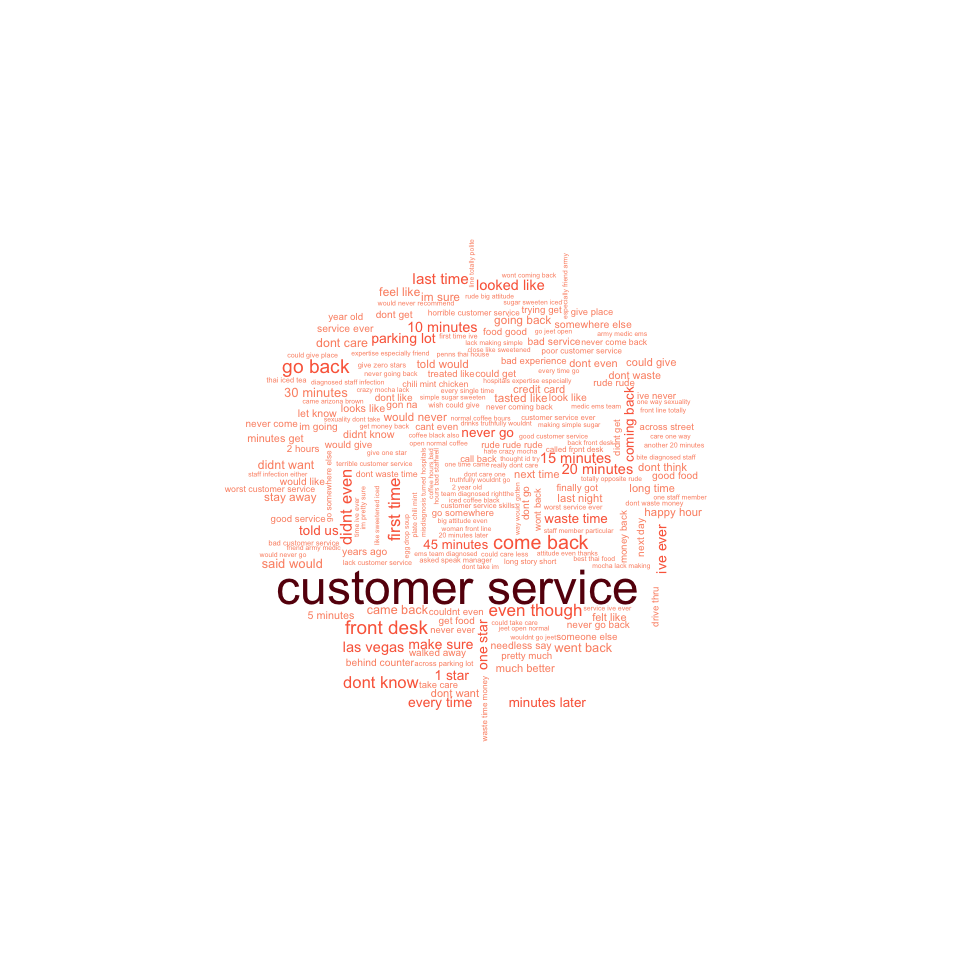

In [35]:
from IPython.core.display import Image
Image(filename=os.path.join(YELP_OUTPUT_DIR, '1_star_wordcloud.png'))

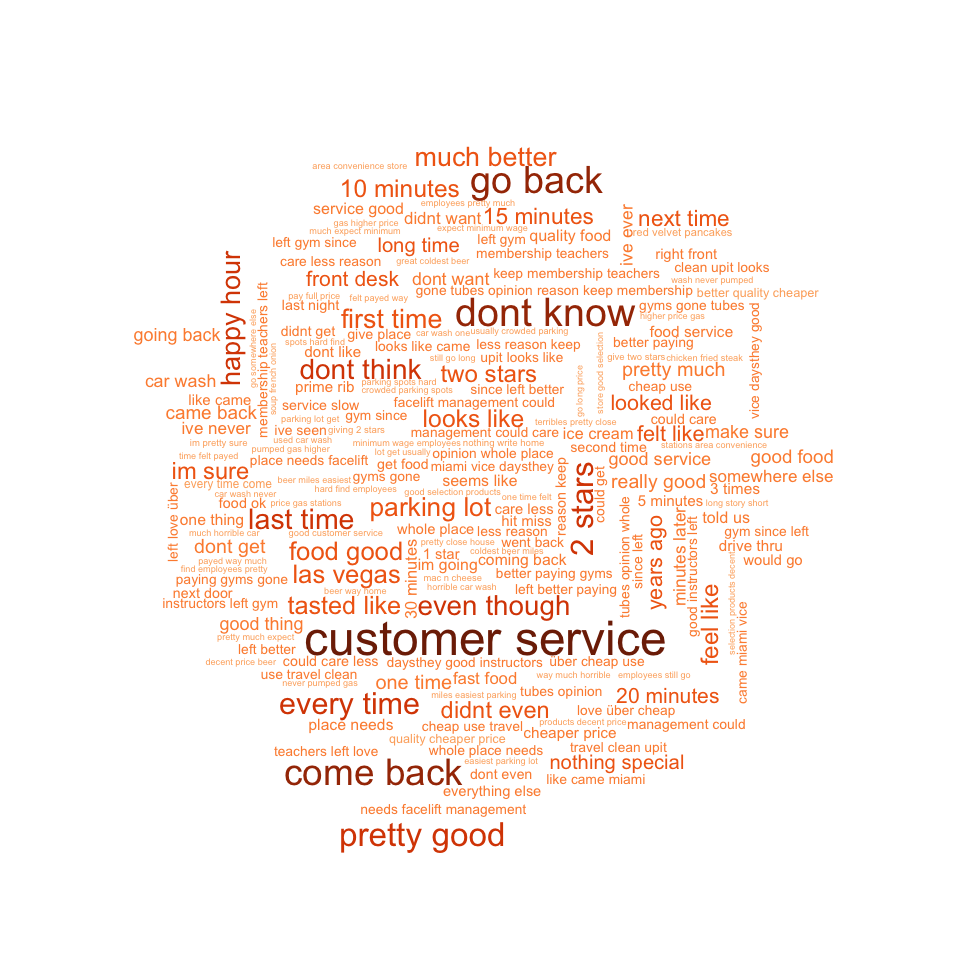

In [36]:
Image(filename=os.path.join(YELP_OUTPUT_DIR, '2_star_wordcloud.png'))

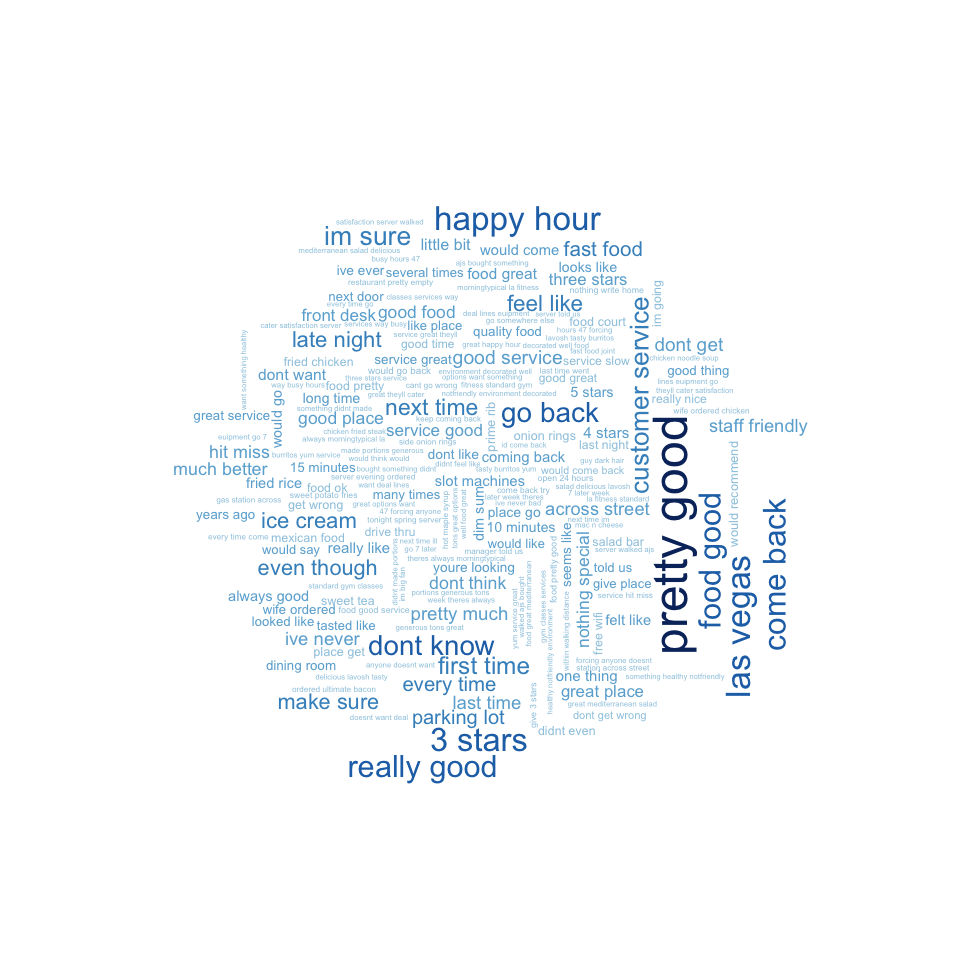

In [37]:
Image(filename=os.path.join(YELP_OUTPUT_DIR, '3_star_wordcloud.png'))

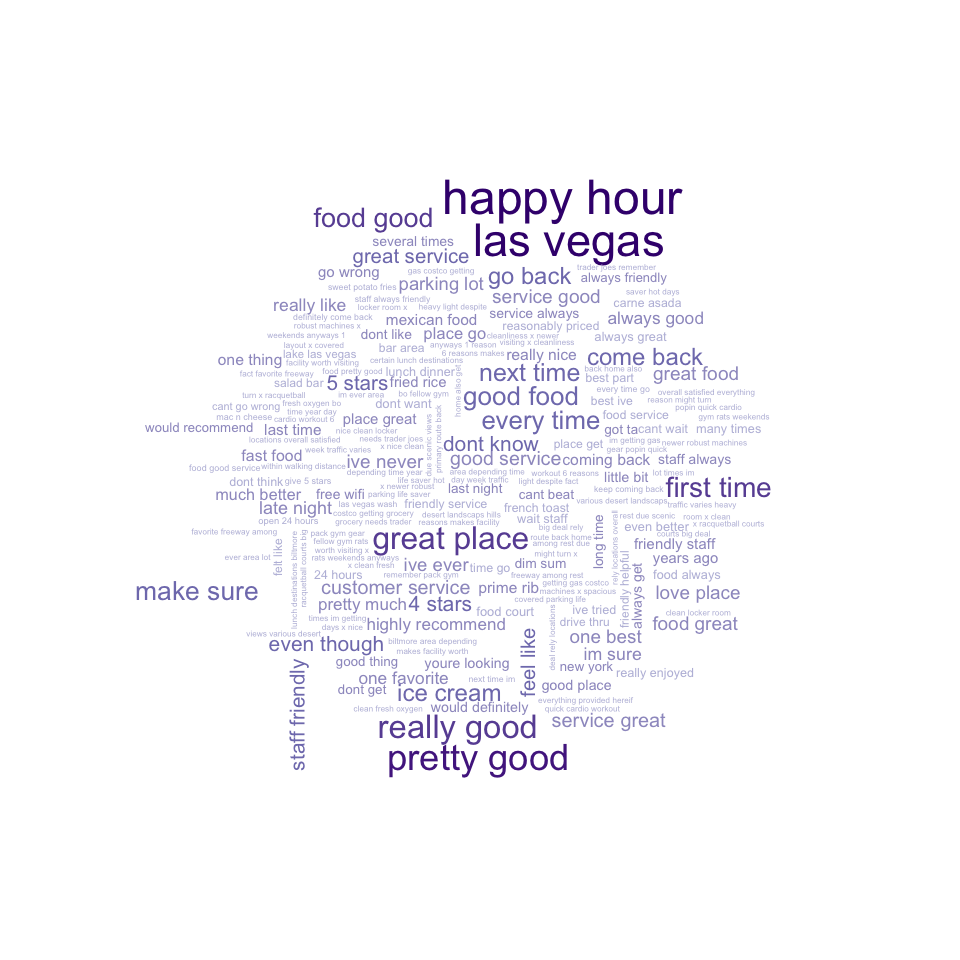

In [38]:
Image(filename=os.path.join(YELP_OUTPUT_DIR, '4_star_wordcloud.png'))

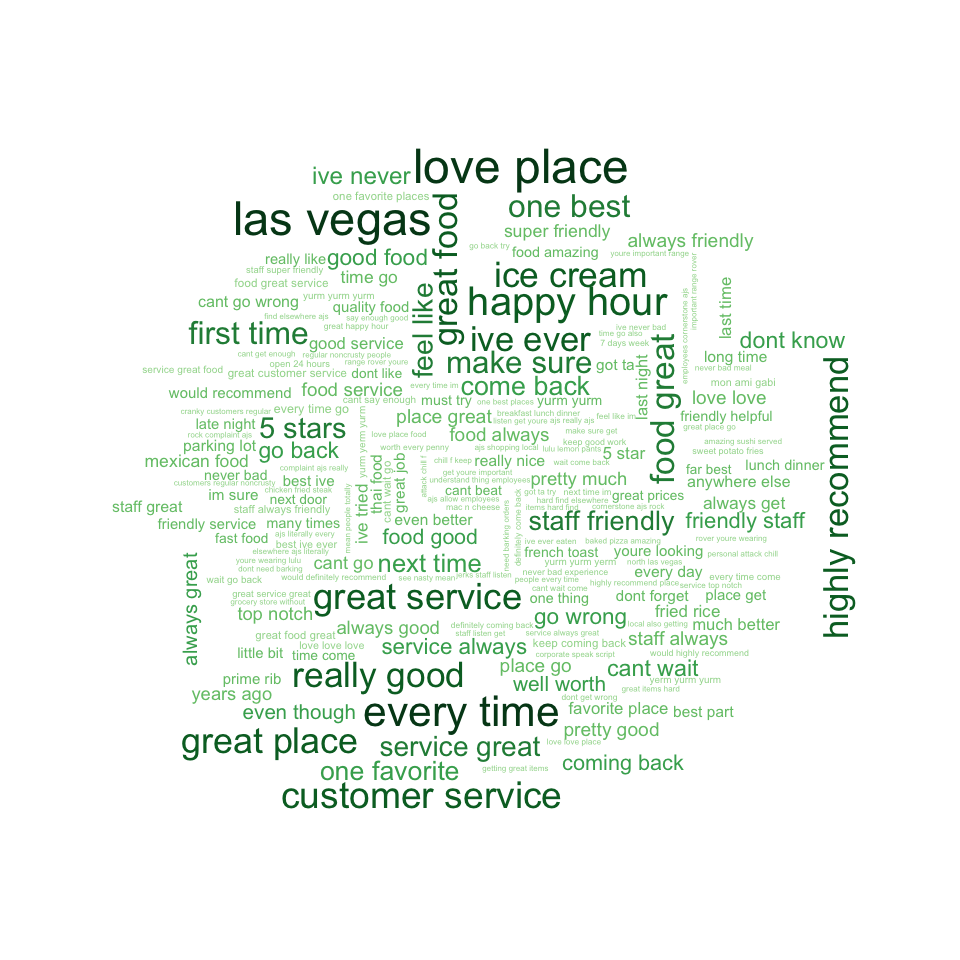

In [39]:
Image(filename=os.path.join(YELP_OUTPUT_DIR, '5_star_wordcloud.png'))

A few common phrases that stand out are "customer service", "front desk", "parking lot", "staff friendly", "las vegas", "come back", numerical data, "one thing", "food good", "ice cream", "happy hour"